In [190]:
import numpy as np
import six,nestle
from sncosmo.utils import Result, Interp1D,ppf
from scipy.interpolate import interp1d as interp
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as multi_gauss

In [262]:
v=50.
g=9.8
measurement_uncertainty=.2#1 percent
times=np.linspace(.1,10,20)
my_model= lambda v,g,t:v*t-.5*g*t**2
perfect_data=v*times-.5*g*times**2
errors=np.ones(len(perfect_data))*5#measurement_uncertainty*perfect_data
heights=np.random.normal(perfect_data,errors)
errors_t=np.ones(len(perfect_data))*.5
#covariance_matrix=np.array([[1.,-.1],[.1,1.]])
covariance_matrix=np.array([[.58309423,13.35681859],
 [13.35681859,501.77276591]])
covariance_matrices=[covariance_matrix]*len(perfect_data)
times_2d=[]
heights_2d=[]
for i in range(len(perfect_data)):
    t,f=np.random.multivariate_normal(
                    mean=[times[i],perfect_data[i]],
                    cov=covariance_matrix)
    times_2d.append(t)
    heights_2d.append(f)
print(np.cov(times_2d[0:3],heights_2d[0:3]))

my_data=Table([times,heights,errors,errors_t],
              names=('time','height','error','error_t'))
my_2d_data=Table([times_2d,heights_2d],names=('time','height'))

[[1.52294600e+00 7.15134640e+01]
 [7.15134640e+01 3.35898624e+03]]


In [263]:
def generate_experiment_error_function(mu, cov):
    def experiment_error_function(Point):
        x = Point
        return multi_gauss.pdf(x, mu, cov)
    return experiment_error_function

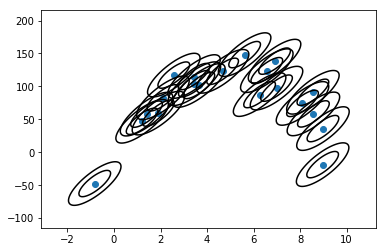

In [264]:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.show()


5.73529792474826e-83
PlugInPointsCount 10000
PointsToPlugInDataset.shape (10000, 2)
PointsToPlugInDataset[0] [ -2. -20.]
Z.shape (100, 100)


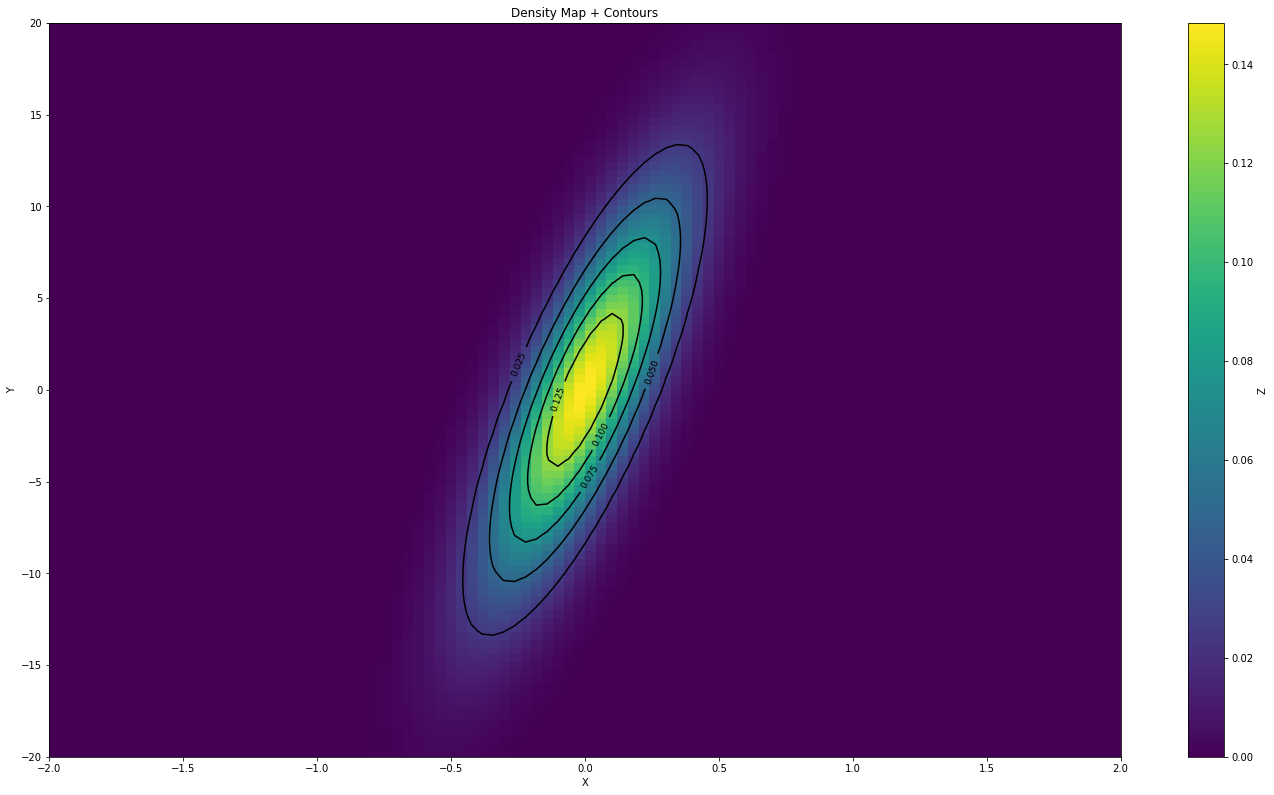

In [255]:


mu = np.array([0,0])
cov = covariance_matrix
experiment_error_function = generate_experiment_error_function(mu, cov)
print ( experiment_error_function( np.array([3,3]) ) )
plot_2d(
    Function = experiment_error_function,
    DomainMinimumPoint  = np.array([-2, -20]),
    DomainMaximumPoint  = np.array([2, 20]),
    ShowContours = True
    )

In [265]:
def bounds_and_priors_to_ppf(bounds,priors=None):
    ppfs={}
    for key, val in six.iteritems(bounds):
        if key in ppfs:
            continue  # ppfs take priority over bounds/priors
        a, b = val
        if priors is not None and key in priors:
            # solve ppf at discrete points and return interpolating
            # function
            x_samples = np.linspace(0., 1., 101)
            ppf_samples = ppf(priors[key], x_samples, a, b)
            f = Interp1D(0., 1., ppf_samples)
        else:
            f = Interp1D(0., 1., np.array([a, b]))
        ppfs[key] = f
    return ppfs

def prior_transform(u):
        d = {}
        for i in range(npdim):
            d[iparam_names[i]] = ppflist[i](u[i])
        v = np.empty(ndim, dtype=np.float)
        for i in range(ndim):
            key = vparam_names[i]
            v[i] = d[key]
        return v

def chisquare(observed_values,expected_values,errors):
    z = (observed_values - expected_values) / errors 
    chi2 = np.sum(z ** 2)
    return(chi2)

def loglike(parameters):
        return -0.5 * chisquare(my_data['height'],
                                my_model(parameters[0],parameters[1],my_data['time']),
                                my_data['error'])
    
def get_marginal_pdfs( vparam_names,weights,samples, bounds,nbins=51, verbose=True ):
    """ Given the results <res> from a nested sampling chain, determine the
    marginalized posterior probability density functions for each of the
    parameters in the model.
    :param res:  the results of a nestlc run
    :param nbins: number of bins (steps along the x axis) for sampling
       each parameter's marginalized posterior probability
    :return: a dict with an entry for each parameter, giving a 2-tuple containing
       NDarrays of length nbins.  The first array in each pair gives the parameter
       value that defines the left edge of each bin along the parameter axis.
       The second array gives the posterior probability density integrated
       across that bin.
    """


    pdfdict = {}
    for param in vparam_names :
        ipar = vparam_names.index( param )
        paramvals = samples[:,ipar]
        
        if nbins>1:
            if param in bounds :
                parvalmin, parvalmax = bounds[param]
            else :
                parvalmin, parvalmax = 0.99*paramvals.min(), 1.01*paramvals.max()
            parambins = np.linspace( parvalmin, parvalmax, nbins, endpoint=True ).flatten()
            binindices = np.digitize( paramvals, parambins )

            # we estimate the marginalized pdf by summing the weights of all points in the bin,
            # where the weight of each point is the prior volume at that point times the
            # likelihood, divided by the total evidence
            pdf = np.array( [ weights[np.where( binindices==ibin )].sum() for ibin in range(len(parambins)) ] )
        else :
            parambins = None
            pdf = None


        mean = (weights  * samples[:,ipar]).sum()
        #print(samples[:,ipar]-mean)
        #print(weights)
        std = np.sqrt( (weights * (samples[:,ipar]-mean)**2 ).sum() )

        pdfdict[param] = (parambins,pdf,mean,std,res.logz)
    return(pdfdict)

def plot_marginal_pdfs(vparam_names,weights,samples, bounds, nbins=101, **kwargs):
    """ plot the results of a classification run
    :return:
    """
    from matplotlib import pyplot as pl
    import numpy as np

    nparam = len(vparam_names)
    # nrow = np.sqrt( nparam )
    # ncol = nparam / nrow + 1
    nrow, ncol = 1, nparam

    pdfdict = get_marginal_pdfs(vparam_names,weights,samples, bounds, nbins)

    fig = plt.gcf()
    for parname in vparam_names :
        iax = vparam_names.index( parname )+1
        ax = fig.add_subplot( nrow, ncol, iax )

        parval, pdf, mean, std, evd = pdfdict[parname]
        ax.plot(  parval, pdf, **kwargs )
        if np.abs(std)>=0.1:
            ax.text( 0.95, 0.95, '%s  %.1f +- %.1f'%( parname, np.round(mean,1), np.round(std,1)),
                     ha='right',va='top',transform=ax.transAxes )
        elif np.abs(std)>=0.01:
            ax.text( 0.95, 0.95, '%s  %.2f +- %.2f'%( parname, np.round(mean,2), np.round(std,2)),
                     ha='right',va='top',transform=ax.transAxes )
        elif np.abs(std)>=0.001:
            ax.text( 0.95, 0.95, '%s  %.3f +- %.3f'%( parname, np.round(mean,3), np.round(std,3)),
                     ha='right',va='top',transform=ax.transAxes )
        else :
            ax.text( 0.95, 0.95, '%s  %.3e +- %.3e'%( parname, mean, std),
                     ha='right',va='top',transform=ax.transAxes )

    plt.draw()

In [266]:
def single_datapoint_likelihood_function(t1,f1,ft,sigma):
    constant=1./np.sqrt(2*np.pi*sigma)
    gauss=constant*np.exp(-(f1-ft)**2./(2.*sigma**2.))
    return(gauss)
    
def multiple_datapoint_likelihood_function(t1s,f1s,fts,sigmas):
    result=1.
    for (t1,f1,ft,sigma) in zip(t1s,f1s,fts,sigmas):
        result*=single_datapoint_likelihood_function(t1,f1,ft,sigma)
        
    return(result)

def single_2d_datapoint_likelihood_function(mu_obs,mu_sample,sigma):
    constant=1./np.sqrt(2*(np.pi**2.)*np.linalg.det(sigma))
    gauss=constant*np.exp(-.5*np.transpose(mu_obs-mu_sample)*np.linalg.inv(sigma)*(mu_obs-mu_sample))
    return(gauss)
    
def multiple_2d_datapoint_likelihood_function(t1s,f1s,sigmas,parameters):
    result=1.
    for (t1,f1,sigma) in zip(t1s,f1s,sigmas):
        sum_2d_gauss=0.
        curve_samples=np.linspace(t1-3*np.sqrt(sigma[0][0]),t1+3*np.sqrt(sigma[0][0]),10)
        for t_sample in curve_samples:
            f_sample=my_model(*np.append(parameters,[t_sample]))
            mu=np.array([t_sample,f_sample])
            x=np.array([t1,f1])
            sum_2d_gauss+=(multi_gauss.pdf(x,mu,sigma)/len(curve_samples))
        
        result*=sum_2d_gauss
    return(result)

def correct_loglikelihood(parameters):
    modeled=np.array([my_model(*np.append(parameters,[x])) for x in my_data['time']])
    observed=my_data['height']
    return(np.log(multiple_2d_datapoint_likelihood_function(my_data['time'],
                                observed,my_model,parameters,covariances)))
    
def correct_2d_loglikelihood(parameters):
    likelihood=np.log(multiple_2d_datapoint_likelihood_function(my_2d_data['time'],
                            my_2d_data['height'],
                            covariance_matrices,parameters))
    
    return(likelihood)
    

/Users/jpierel/anaconda3/envs/sntd_test3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


['v', 'g'] [49.32634922  9.82898557]
['v', 'g'] [[10.9222615   3.25135978]
 [ 3.25135978  1.12378814]]


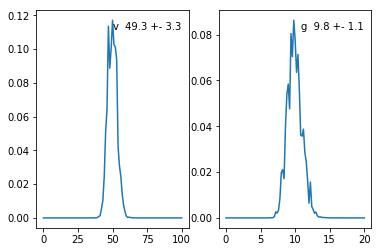

In [267]:
npoints=100
method='single'
maxiter=None
maxcall=None
rstate=None
verbose=False
vparam_names = ['v','g']
bounds={'v':(0,100),'g':(0,20)}
ppfs=bounds_and_priors_to_ppf(bounds)
iparam_names = [key for key in vparam_names if key in ppfs]
ppflist = [ppfs[key] for key in iparam_names]
npdim = len(iparam_names)  # length of u
ndim = len(vparam_names)  # length of v
res = nestle.sample(correct_2d_loglikelihood, prior_transform, ndim, npdim=npdim,
                        npoints=npoints, method=method, maxiter=maxiter,
                        maxcall=maxcall, rstate=rstate,
                        callback=(nestle.print_progress if verbose else None))

vparameters, cov = nestle.mean_and_cov(res.samples, res.weights)
print(vparam_names,vparameters)
print(vparam_names,cov)
plot_marginal_pdfs(vparam_names,res.weights,res.samples,bounds,nbins=101)

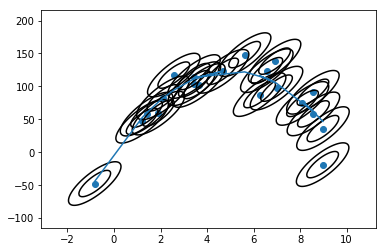

In [268]:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.plot(my_2d_data['time'],my_model(vparameters[0],vparameters[1],
                                  my_2d_data['time']))
plt.show()


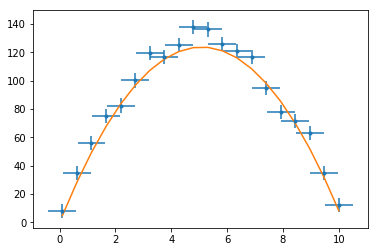

In [160]:
plt.errorbar(my_data['time'],my_data['height'],xerr=my_data['error_t'],
             yerr=my_data['error'],fmt='.')
#plt.errorbar(my_data['time'],perfect_data,yerr=my_data['error'],fmt='.')
plt.plot(my_data['time'],my_model(vparameters[0],vparameters[1],my_data['time']))

In [139]:
np.product

<function numpy.product(*args, **kwargs)>

In [147]:
temp=[1,1,1]
my_model(*temp)

0.5

/Users/jpierel/anaconda3/envs/sntd_test3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  if sys.path[0] == '':
/Users/jpierel/anaconda3/envs/sntd_test3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  
/Users/jpierel/anaconda3/envs/sntd_test3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  from ipykernel import kernelapp as app
/Users/jpierel/anaconda3/envs/sntd_test3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  app.launch_new_instance()


ValueError: Contour levels must be increasing

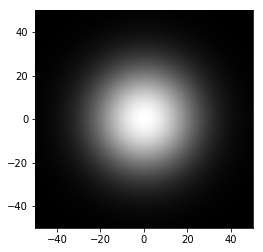

In [246]:
import numpy
def Library_DatasetGetMaximumDatapoint(Dataset = None):
	DatasetTranspose = Dataset.T
	DatasetDimensionMinimums = []
	for DimensionValues in DatasetTranspose:
		DatasetDimensionMinimums.append(max(DimensionValues))
	Result = numpy.array(DatasetDimensionMinimums)
	return Result

import numpy

def Library_DatasetGetMinimumDatapoint(Dataset):
	DatasetTranspose = Dataset.T
	DatasetDimensionMinimums = []
	for DimensionValues in DatasetTranspose:
		DatasetDimensionMinimums.append(min(DimensionValues))
	Result = numpy.array(DatasetDimensionMinimums)
	return Result
import numpy
#------------------------------------------------------------------------------

def Type_NumpyTwoDimensionalDataset(
    Dataset = None, 
    PrintExtra = False
    ):

    #Must not be null
    if Dataset is None:
        if (PrintExtra):
            print("Emtpy Dataset: Must not be null")
        return False 

    #Type Numpy Array
    if ( str(type(Dataset)) != "<type 'numpy.ndarray'>" ):
        if (PrintExtra):
            print("DatasetType:  must be Type Numpy Array")
        return False
    
    #Must be Two Code Dimensions (even for N-Dimensional Datasets)
    if (len(Dataset.shape) != 2):
        if (PrintExtra):
            print("len(Dataset.shape) != 2: Must be Two Code Dimensions (even for N-Dimensional Datasets)")
        return False

    #For N-Dimensional datasets - they must be at least 1 dimension
    if (Dataset.shape[0] < 1): 
        if (PrintExtra):
            print("DatasetShape[0] < 1:  For N-Dimensional datasets - they must be at least 1 dimension")
        return False

    #For N-Dimensional datasets - they must have at least 1 observation
    if (Dataset.shape[1] < 1):
        if (PrintExtra):
            print("DatasetShape[1] < 1 For N-Dimensional datasets - they must have at least 1 observation")
        return False
        
    return True
"""
DESCRIPTION:
    Graph an arbitrary function of 2 variables
    3d graph tends to be difficult to view because of angle
    2d heat map is likely to be a better choice


    Matplotlib Compatability:
        This function does not play nice with other graphs:
        Does not allow for graphing additional things on the same plot:
            fig = plt.figure() 
                Included in this method
            plt.draw() 
                Included in this method
        Can still be called amist other programs without a delay, because plt.show() is not invoked


ARGS (9 Count):
    Function:
        python function which has ARGS (1 count):
            Point:
                numpy array of two values
                point looks like [x_coord, y_coord]

        GraphTwoDimensionalDensityColorMap is designed to graph on 3 dimmensional coordinates
        Point == [x,y]
        F( Point )  => returns z

 
    DomainMinimumPoint:
        used for plot boundaries
        numpy array of two values:
            [x_min, y_min]

    DomainMaximumPoint:
        used for plot boundaries
        numpy array of two values:
            [x_max, y_max]

    ObservedDataset:
        Type_NumpyTwoDimensionalDataset
            [point, point, ...,  point]
        Used for scatter presentation

    PlotThreeDimensional:
        The plot generated will be a heat map regardless of choice with color correpsonding to density
        This can be two values:
            True
                Show visual third dimension and look at the surface from a fixed point
                Cannot plot contours
            False
                2D plot
                Will show contours

    Xlabel: ...
    Ylabel: ...
    Zlabel: ...


RETURNS:
    None

"""
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import numpy
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#------------------------------------------------------------------------------



def plot_2d( 
    Function = None, 
    DomainMinimumPoint = None, 
    DomainMaximumPoint = None, 
    ObservedDataset = None, 
    PlotThreeDimensional = False, 
    ShowContours = False, 
    Xlabel = "X", 
    Ylabel = "Y", 
    Zlabel = "Z",
    LogX = False,
    LogY = False, 
    CheckArguments = True,  
    SaveFigureFilePath = None,
    PrintExtra = None,
    ):
    
    if PrintExtra is None:
        PrintExtra = False
    
    if (CheckArguments): 
        ArgumentErrorMessage = ""
        #TODO: Match dataset and function dimensions

        if (Type_NumpyTwoDimensionalDataset(ObservedDataset) != True ):
            if (DomainMaximumPoint is None or DomainMinimumPoint is None ):
                ArgumentErrorMessage += "(Type_NumpyTwoDimensionalDataset(ObservedDataset) != True)\n"
                if (ObservedDataset is None):
                    ArgumentErrorMessage += "(ObservedDataset is None)\n"
                if (DomainMinimumPoint  is None):
                    ArgumentErrorMessage += "(DomainMinimumPoint  is None)\n"
                if (DomainMaximumPoint  is None):
                    ArgumentErrorMessage += "(DomainMaximumPoint  is None)\n"

        if (len(ArgumentErrorMessage) > 0 ):
            if (PrintExtra):
                print("ArgumentErrorMessage:\n", ArgumentErrorMessage)
            raise Exception(ArgumentErrorMessage)

    #Arg Fixing / Inferring (very pythonic - i know) 
    #Extract all the observations in X, Y coordinates:
    if (ObservedDataset != None):
        ObservedX = ObservedDataset.T[0]
        ObservedY = ObservedDataset.T[1]
    else:
        ObservedX = numpy.array([])
        ObservedY = numpy.array([])

    #If a dataset was passed, and min/max plot domain not passed:
    #   infer the plot domain minimums and maximums from the dataset
    if (DomainMinimumPoint  is None):
        DomainMinimumPoint  = numpy.nanmin(ObservedDataset, axis = 0)
    if (DomainMaximumPoint  is None):
        DomainMaximumPoint  = numpy.nanmax(ObservedDataset, axis = 0) 
    xrng = DomainMaximumPoint [0] - DomainMinimumPoint [0]
    xmin = DomainMinimumPoint [0] #- xrng*0.2
    xmax = DomainMaximumPoint [0] #+ xrng*0.2    

    yrng = DomainMaximumPoint [1] - DomainMinimumPoint [1]
    ymin = DomainMinimumPoint [1] #- yrng*0.2
    ymax = DomainMaximumPoint [1] #+ yrng*0.2

    #Using the minimum and maximum points, we create a meshgrid of points
    #   This grid of points will be plugged into the function
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)

    print('PlugInPointsCount', PlugInPointsCount)
    print('PointsToPlugInDataset.shape', PointsToPlugInDataset.shape)
    print('PointsToPlugInDataset[0]', PointsToPlugInDataset[0])

    #Plug in each point into the function which is contained in the meshgrid
    #   Keep track of the values, and store them as "Z" coordinates
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)

    print('Z.shape', Z.shape)

    #print 'Z', Z

    #Plug in the observed points to get thier Z-values:
    if (ObservedDataset != None):
        k = 0 
        ObservedPointsCount = len(ObservedDataset)
        ObservedZ = numpy.zeros((ObservedPointsCount))
        while (k < ObservedPointsCount ):
            PointToPlugIn = ObservedDataset[k]
            FunctionValueForPointToPlugIn = Function(PointToPlugIn)
            ObservedZ[k] = FunctionValueForPointToPlugIn
            k = k + 1


    zmin = numpy.min(Z) # This should always be 1 dimension
    zmax = numpy.max(Z) # This should always be 1 dimension
    zrange = zmax - zmin
    

    #size the graphs
    #   Default to common monitor size:  
    #   1920pixels by 1080 pixels
    Inch_in_Pixels = 80.0
    MonitorSize = (1920.0/Inch_in_Pixels,1080.0/Inch_in_Pixels)

    fig = matplotlib.pyplot.figure(figsize=MonitorSize) #figsize=MonitorSize

    #matplotlib.pyplot.subplots_adjust(bottom=0.14)

    #Design the plot with the coordinate values (this could be done in it's own function)
    #fig = plt.figure()
    if (PlotThreeDimensional == True):
        subplot = fig.add_subplot(111, projection='3d')
        
        #Draw the mesh:
        surface = subplot.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.gist_earth_r) #cmap=cm.YlGnBu_r)
        fig.colorbar( surface )    

        #Draw a contour( This blows ):
        #contour = subplot.contour(X,Y,Z,extend3d=True )

        #Draw observations - veritical lines at each point (somehow this blows too):
        #k = 0
        #while k < ObservedPointsCount:
        #    subplot.plot( [ObservedX[k],ObservedX[k]],  [ObservedY[k], ObservedY[k]],  [ObservedZ[k] , ObservedZ[k] + zrange/20], 'w-', lw = 5 )
        #    k = k + 1
    
        #Draw observations - points in 3d (This blows ):
        #subplot.scatter(ObservedX, ObservedY, ObservedZ, marker= 'o', s=100, c = 'white')

        #ax.set_zlim3d(0, 1)
        subplot.set_xlabel(Xlabel)
        subplot.set_ylabel(Ylabel)
        subplot.set_zlabel(Zlabel)        

    else:

        #From http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

        subplot = matplotlib.pyplot.subplot(111)
        #matplotlib.pyplot.subplot(2,1,2)


        #aspectratio = xrng / yrng
        aspectratio = 'auto'

        heatmap = subplot.imshow( 
        #heatmap = matplotlib.pyplot.imshow(
        #heatmap = matplotlib.pyplot.imshow(
            numpy.rot90(Z), 
            #cmap=plt.cm.gist_earth_r, 
            extent=[xmin, xmax, ymin, ymax] ,
            aspect = aspectratio ,
            interpolation = None,
            #norm=LogNorm(vmin=0.01, vmax=1)
            )  


        #Add color bar (showing Z-axis sense of scale)
        matplotlib.pyplot.colorbar( heatmap, label = Zlabel )

        #matplotlib.pyplot.tight_layout()

        #Add the observations:
        if (ObservedDataset != None):
            matplotlib.pyplot.plot(ObservedX, ObservedY, 'k.', markersize=2)

        #Set image boundaries:
        #subplot.set_xlim([xmin, xmax])
        #subplot.set_ylim([ymin, ymax])
        subplot.set_xlabel(Xlabel)
        subplot.set_ylabel(Ylabel)
        #plt.axis([xmin, xmax, ymin, ymax])
        #matplotlib.pyplot.autoscale(axis='y')
        #heatmap.set_aspect(1)


        #subplot.set_xscale('log')


        #Plot Countours: ( From http://matplotlib.org/examples/pylab_examples/contour_demo.html )
        if( ShowContours ):
            CS = plt.contour(X, Y, Z, 6,
                             colors='k', # negative contours will be dashed by default
                             )

            plt.clabel(CS, fontsize=9, inline=1)

            plt.title("Density Map + Contours")
        else:
            plt.title("Density Map")



    if (SaveFigureFilePath != None):
        plt.savefig( SaveFigureFilePath )

    plt.draw()





    """
    #Extract boundary regions (minimum and maximum points)
    if (DomainMinimumPoint  is None):

            DomainMinimumPoint  = Library_DatasetGetMinimumDatapoint.Main(ObservedDataset)
        else:
            #Better: We have to spotcheck infer where the Z axis ranges with monte-carlo
            raise Exception("DomainMinimumPoint not defined")
    if (DomainMaximumPoint  is None):
        if (ObservedDataset != None):
            DomainMaximumPoint  = Library_DatasetGetMaximumDatapoint.Main(ObservedDataset)
        else:
            raise Exception("DomainMaximumPoint not defined")
    """